In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config_df = pd.read_csv("sbert.csv")
epoch_df = pd.read_csv("sbert_epoch.csv")
epoch_df.head()
config_df.head()

,config_id,type_test,model_name,pooling_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,weight_decay,...,peak_memory,reg_train_loss,reg_train_rmse,reg_train_pearson,reg_valid_loss,reg_valid_rmse,reg_valid_pearson,reg_test_loss,reg_test_rmse,reg_test_pearson
0,0,model_test,sentence-transformers/distiluse-base-multiling...,mean,16,7,0.00002,0.1,0.1,0.01,...,7028.749512,0.001465,0.038271,0.990858,0.037407,0.193408,0.815025,0.018751,0.136935,0.887178
1,1,model_test,sentence-transformers/distiluse-base-multiling...,cls,16,7,0.00002,0.1,0.1,0.01,...,7543.395996,0.001590,0.039877,0.990070,0.035002,0.187089,0.789624,0.019669,0.140246,0.879829
2,2,model_test,sentence-transformers/distiluse-base-multiling...,max,16,7,0.00002,0.1,0.1,0.01,...,8042.776855,0.001575,0.039689,0.990164,0.028789,0.169672,0.844629,0.025262,0.158939,0.864244
3,3,model_test,sentence-transformers/distiluse-base-multiling...,attention,16,6,0.00002,0.1,0.1,0.01,...,7028.745605,0.001159,0.034049,0.992771,0.035221,0.187672,0.820167,0.019076,0.138117,0.875195


# Training Plot

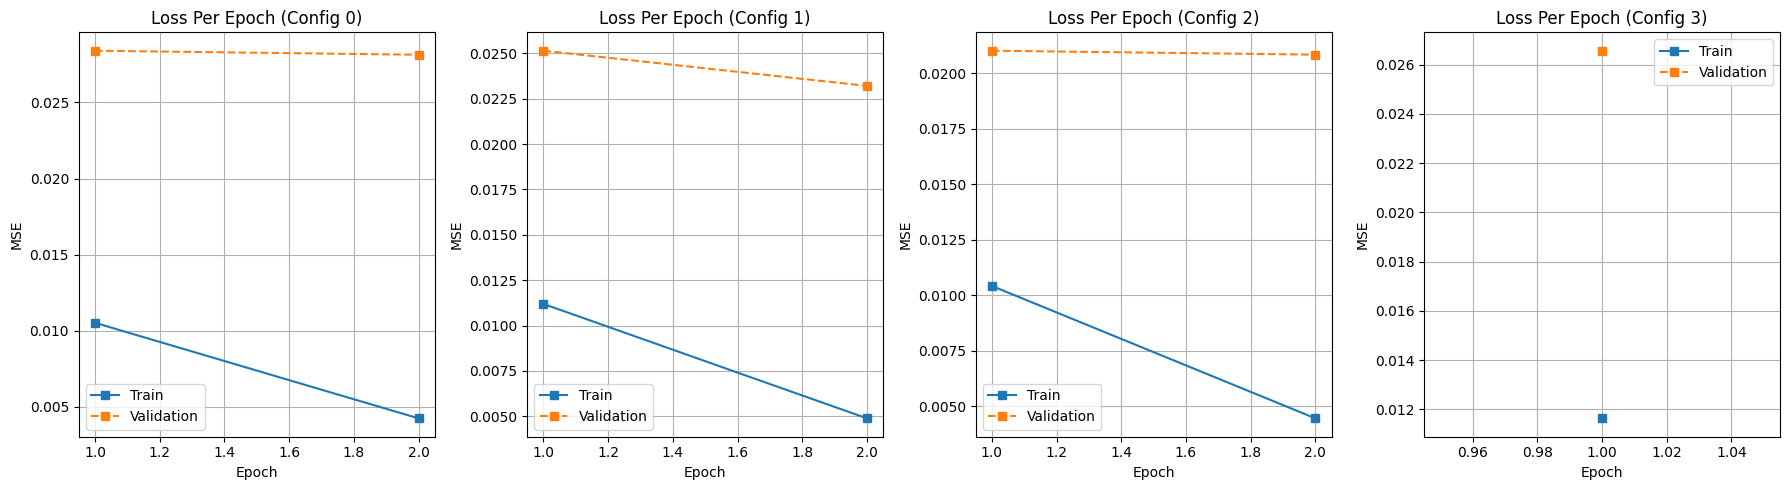

In [3]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 4, figsize=(18, 5))  # 1 row, 3 columns

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


# Scatter Plot with Regression Line

In [4]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import AutoTokenizer
from main_similarity import SiameseModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import joblib

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/distiluse-base-multilingual-cased-v2")

def compute_cosine_similarity(dataloader, model):
        all_outputs = []
        all_scores = []
        with torch.no_grad():
            for batchs in dataloader:
                batchs = {
                    k: {kk: vv.to("cuda") for kk, vv in v.items()} if isinstance(v, dict) else v.to("cuda")
                    for k, v in batchs.items()
                }
                
                # get embedding for each student and reference answer
                reference_emb = model(batchs['reference_answer']['input_ids'], batchs['reference_answer']['attention_mask'])
                student_emb = model(batchs['student_answer']['input_ids'], batchs['student_answer']['attention_mask'])
                scores = batchs['labels'].float().view(-1)

                # Normalize embeddings
                ref_embedding = F.normalize(reference_emb, p=2, dim=1)
                student_embedding = F.normalize(student_emb, p=2, dim=1)

                # get cosine similarity
                similarity = F.cosine_similarity(ref_embedding, student_embedding, dim=1)
                similarity = torch.clamp(similarity, -1.0, 1.0)

                all_outputs.append(similarity)
                all_scores.append(scores)

        # Concatenate all batches
        X = torch.cat(all_outputs, dim=0).cpu().numpy()
        y = torch.cat(all_scores, dim=0).cpu().numpy()

        return X, y

def predict(df_test, config_id, model):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    
    checkpoint = torch.load(f"../../../models/pooling/cross/sbert_{config_id}.pt", map_location='cuda', weights_only=True)
    reg_model = joblib.load(f"../../../models/pooling/cross/reg_{config_id}.pkl")
    model.load_state_dict(checkpoint)
    model.eval()
    X_test, y_test = compute_cosine_similarity(test_dataloader, model)
    y_test_pred = reg_model.predict(X_test.reshape(-1, 1))

    return y_test_pred, y_test

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [5]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/cross/test_indo.csv")
for row in config_df.itertuples():
    model = SiameseModel("sentence-transformers/distiluse-base-multilingual-cased-v2", pooling_type=row.pooling_type).to('cuda')
    all_predictions, all_targets = predict(df_test, row.config_id, model)

    # Tambahkan prediksi ke df_test
    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "sbert_prediction.csv"))

c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:402: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



>> Mean Pooling
RMSE: 0.1452, Pearson: 0.8674

>> CLS Pooling
RMSE: 0.1238, Pearson: 0.8766

>> Max Pooling
RMSE: 0.1661, Pearson: 0.8433

>> Attention Pooling
RMSE: 0.1486, Pearson: 0.8559


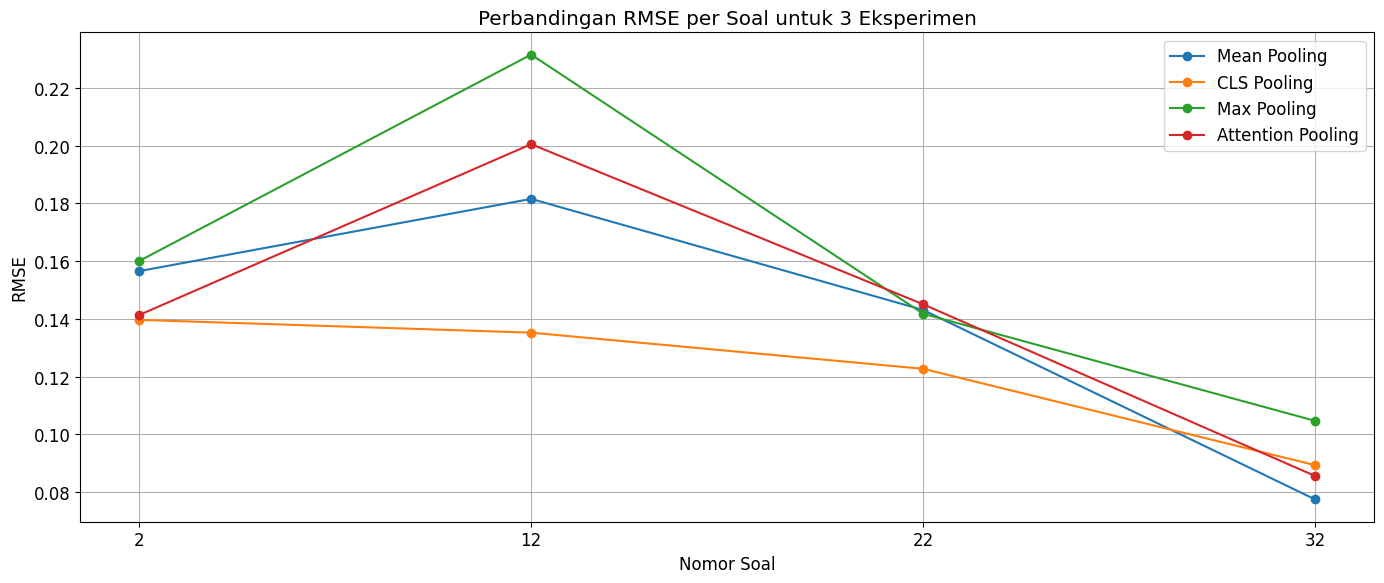

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

# Folder inference
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv") and f.startswith("sbert")]

# Warna akan di-generate otomatis tergantung jumlah eksperimen
color_palette = plt.get_cmap("tab10")  # Bisa memuat hingga 10 warna berbeda

# Label eksperimen bisa ditentukan manual berdasarkan nama kolom prediksi
label_map = {
    "predicted_score_0": "Mean Pooling",
    "predicted_score_1": "CLS Pooling",
    "predicted_score_2": "Max Pooling",
    "predicted_score_3": "Attention Pooling",
}

# Dictionary untuk menyimpan RMSE per soal dari tiap eksperimen
rmse_per_model = {}
metric_eval_data = {}
# Buat scatter plot dan hitung RMSE per soal
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        # Hitung metrik global
        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col)  # Default pakai nama kolom kalau tidak ditemukan
        print(f"\n>> {label}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        # Hitung RMSE per soal
        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

# Ekstrak nomor soal dari dataset_num (misalnya 'analisis_essay-19' -> 19)
def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

# Plot gabungan RMSE per soal
plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    # Ekstrak nomor soal
    soal_numbers = extract_soal_number(rmse_series.index)
    
    # Gabungkan kembali ke Series dengan index numerik
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    # Plot
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique()))  # Lebih rapi dan terbaca
plt.tight_layout()
plt.show()



In [12]:
fixed_threshold = 0.1

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))

model_data = sorted(model_data, key=lambda x: x[0])


# Visualisasi scatter plot untuk tiap model
num_models = len(model_data)
outlier_count = {}

for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    # Deteksi outlier IQR global & fixed threshold
    outlier_fixed2 = np.abs(residuals) > 0.2
    outlier_fixed = np.abs(residuals) > fixed_threshold

        # Hitung jumlah outlier
    num_outliers_fixed2 = np.sum(outlier_fixed2)
    num_outliers_fixed = np.sum(outlier_fixed)

    # Cetak hasil
    print(f"{label}:")
    print(f"  Outlier (Fixed ±0.2): {num_outliers_fixed2}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")
    outlier_count[label] = {
        "IQR Fixed Threshold ±0.2": num_outliers_fixed2,
        "IQR Fixed Threshold ±0.1": num_outliers_fixed
    }

Attention Pooling:
  Outlier (Fixed ±0.2): 36
  Outlier (Fixed ±0.1): 96

CLS Pooling:
  Outlier (Fixed ±0.2): 19
  Outlier (Fixed ±0.1): 88

Max Pooling:
  Outlier (Fixed ±0.2): 53
  Outlier (Fixed ±0.1): 108

Mean Pooling:
  Outlier (Fixed ±0.2): 32
  Outlier (Fixed ±0.1): 100



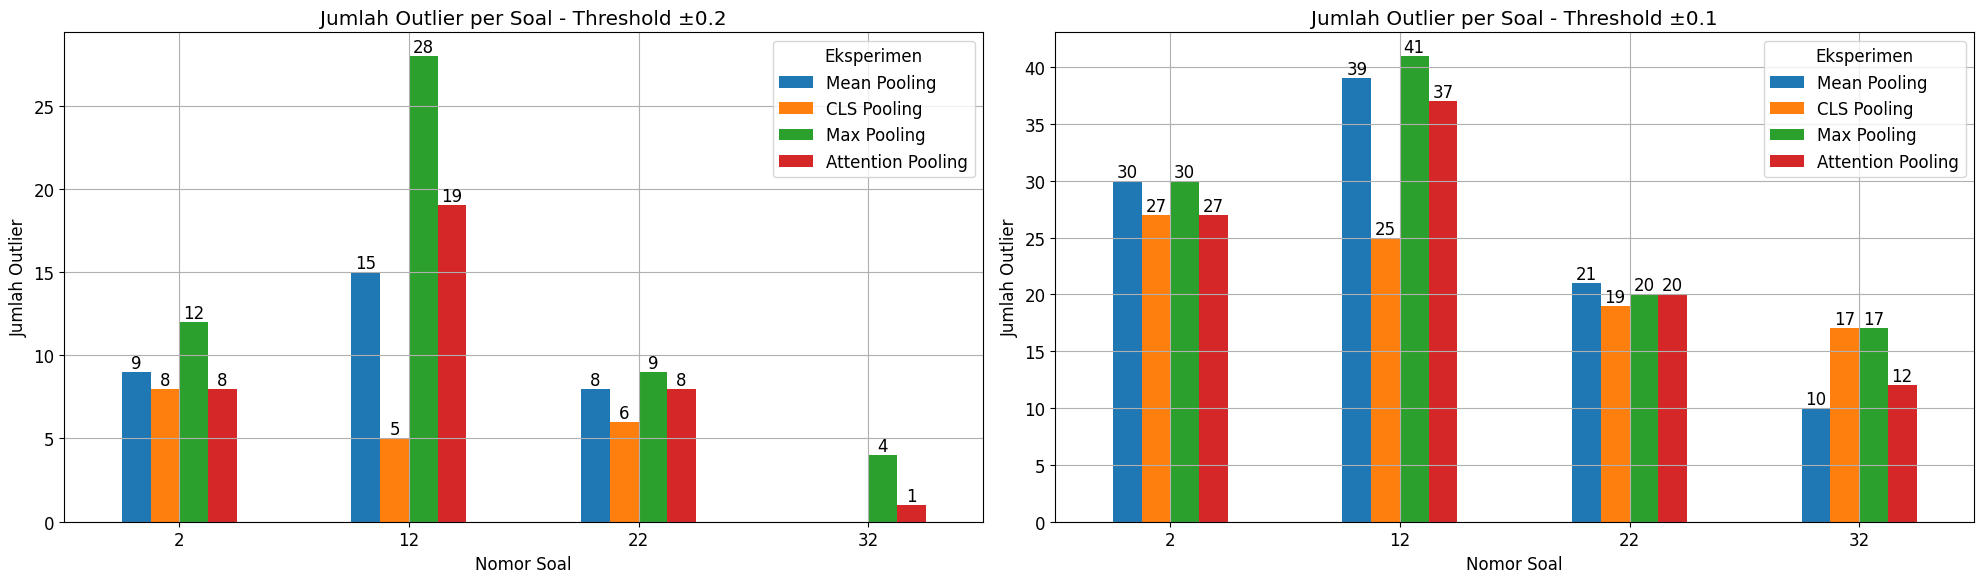

In [13]:
outlier_counts_fixed1 = {}
outlier_counts_fixed2 = {}

# Fixed threshold
fixed_threshold1 = 0.1
fixed_threshold2 = 0.2

# Step 3: Hitung jumlah outlier per soal (IQR Global & Fixed)
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_fixed1 = np.abs(residuals) > fixed_threshold1
        outlier_mask_fixed2 = np.abs(residuals) > fixed_threshold2

        df['outlier_fixed1'] = outlier_mask_fixed1
        df['outlier_fixed2'] = outlier_mask_fixed2

        label = label_map.get(col, col)

        # Fixed Threshold
        fixed_counts1 = df[df['outlier_fixed1']].groupby('soal_num').size()
        outlier_counts_fixed1[label] = fixed_counts1

        fixed_counts2 = df[df['outlier_fixed2']].groupby('soal_num').size()
        outlier_counts_fixed2[label] = fixed_counts2

df_fixed1 = pd.DataFrame(outlier_counts_fixed1).fillna(0).astype(int).sort_index()
df_fixed2 = pd.DataFrame(outlier_counts_fixed2).fillna(0).astype(int).sort_index()

plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot untuk Threshold ±0.2
df_fixed2.plot(kind='bar', ax=ax1)
ax1.set_title("Jumlah Outlier per Soal - Threshold ±0.2")
ax1.set_xlabel("Nomor Soal")
ax1.set_ylabel("Jumlah Outlier")
ax1.grid(True)
ax1.legend(title="Eksperimen", fontsize=12, title_fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)

# Tambahkan teks di atas bar (ax1)
for container in ax1.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12
            )

# Plot untuk Threshold ±0.1
df_fixed1.plot(kind='bar', ax=ax2)
ax2.set_title("Jumlah Outlier per Soal - Threshold ±0.1")
ax2.set_xlabel("Nomor Soal")
ax2.set_ylabel("Jumlah Outlier")
ax2.grid(True)
ax2.legend(title="Eksperimen", fontsize=12, title_fontsize=12)
ax2.tick_params(axis='x', rotation=0, labelsize=12)

# Tambahkan teks di atas bar (ax2)
for container in ax2.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax2.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12
            )

plt.tight_layout()
plt.show()


In [14]:
print("Metrik Evaluation")
print(metric_eval_data)
print("Jumlah Outlier Per Metode IQR")
print(outlier_count)
print("Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.1")
print(df_fixed1.to_json())
print("Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.2")
print(df_fixed2.to_json())

Metrik Evaluation
{'Mean Pooling': {'RMSE': 0.1452, 'Pearson': 0.8674}, 'CLS Pooling': {'RMSE': 0.1238, 'Pearson': 0.8766}, 'Max Pooling': {'RMSE': 0.1661, 'Pearson': 0.8433}, 'Attention Pooling': {'RMSE': 0.1486, 'Pearson': 0.8559}}
Jumlah Outlier Per Metode IQR
{'Attention Pooling': {'IQR Fixed Threshold ±0.2': 36, 'IQR Fixed Threshold ±0.1': 96}, 'CLS Pooling': {'IQR Fixed Threshold ±0.2': 19, 'IQR Fixed Threshold ±0.1': 88}, 'Max Pooling': {'IQR Fixed Threshold ±0.2': 53, 'IQR Fixed Threshold ±0.1': 108}, 'Mean Pooling': {'IQR Fixed Threshold ±0.2': 32, 'IQR Fixed Threshold ±0.1': 100}}
Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.1
{"Mean Pooling":{"2":30,"12":39,"22":21,"32":10},"CLS Pooling":{"2":27,"12":25,"22":19,"32":17},"Max Pooling":{"2":30,"12":41,"22":20,"32":17},"Attention Pooling":{"2":27,"12":37,"22":20,"32":12}}
Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.2
{"Mean Pooling":{"2":9,"12":15,"22":8,"32":0},"CLS Pooling":{"2":8,"12":5,"22":6,"32":0},"M

In [13]:
# import json

# interesting_num = [16, 29, 37]
# for file in csv_files:
#     df = pd.read_csv(os.path.join(inference_dir, file))
#     true_scores = df['normalized_score'].values
#     pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
#     df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

#     for col in pred_cols:
#         residuals = df[col].values - true_scores
#         outlier_mask = np.abs(residuals) > fixed_threshold

#         subset_iqr = df[outlier_mask][['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
#         subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
#         if not subset_iqr.empty:
#             print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
#             print(subset_iqr.to_json(orient="records", indent=2, force_ascii=False))
